## Procesamiento y Clasificación de Datos

#### Tarea 2 Análisis de Sentimiento
#### Estudiante: Orestes Boffill Beltrán
#### Matrícula: 2085377
#### Maestría de Ciencia de Datos

## Librerías

In [1]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import string
import re

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
#style.use('ggplot') or plt.style.use('ggplot')

# Preprocesado y modelado
# ==============================================================================
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

## Carga de la Base de Datos a analizar
#### la Base de Datos contiene tweets y provienen originalmente de la biblioteca "Data for Everyone de Crowdflower", descargada desde: https://www.kaggle.com/datasets/crowdflower/first-gop-debate-twitter-sentiment
#### Contiene decenas de miles de tweets sobre el debate republicano de principios de agosto en Ohio y se le pidió a los contribuyentes que hicieran análisis de sentimientos y de categorización de datos. Se preguntó a los colaboradores si el tweet era relevante, qué candidato se mencionó, qué tema se mencionó y luego cuál era el sentimiento para un tweet determinado. Los mensajes no relevantes del conjunto de datos cargado fueron eliminados previamente.

In [2]:
df = pd.read_csv('E:/MCD/Documentos/Sentiment.csv')
df.head()

,id,candidate,candidate_confidence,relevant_yn,relevant_yn_confidence,sentiment,sentiment_confidence,subject_matter,subject_matter_confidence,candidate_gold,...,relevant_yn_gold,retweet_count,sentiment_gold,subject_matter_gold,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,1,No candidate mentioned,1.0,yes,1.0,Neutral,0.6578,None of the above,1.0000,NaN,...,NaN,5,NaN,NaN,RT @NancyLeeGrahn: How did everyone feel about...,NaN,2015-08-07 09:54:46 -0700,629697200650592256,NaN,Quito
1,2,Scott Walker,1.0,yes,1.0,Positive,0.6333,None of the above,1.0000,NaN,...,NaN,26,NaN,NaN,RT @ScottWalker: Didn't catch the full #GOPdeb...,NaN,2015-08-07 09:54:46 -0700,629697199560069120,NaN,NaN
2,3,No candidate mentioned,1.0,yes,1.0,Neutral,0.6629,None of the above,0.6629,NaN,...,NaN,27,NaN,NaN,RT @TJMShow: No mention of Tamir Rice and the ...,NaN,2015-08-07 09:54:46 -0700,629697199312482304,NaN,NaN
3,4,No candidate mentioned,1.0,yes,1.0,Positive,1.0000,None of the above,0.7039,NaN,...,NaN,138,NaN,NaN,RT @RobGeorge: That Carly Fiorina is trending ...,NaN,2015-08-07 09:54:45 -0700,629697197118861312,Texas,Central Time (US & Canada)
4,5,Donald Trump,1.0,yes,1.0,Positive,0.7045,None of the above,1.0000,NaN,...,NaN,156,NaN,NaN,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,NaN,2015-08-07 09:54:45 -0700,629697196967903232,NaN,Arizona


In [3]:
dataset = df.drop(['id', 'candidate_confidence', 'relevant_yn', 'relevant_yn_confidence', 'subject_matter', 'subject_matter_confidence', 'candidate_gold', 'relevant_yn_gold','sentiment_gold','subject_matter_gold','tweet_coord','tweet_id','tweet_location'], axis =1)
dataset.head()

,candidate,sentiment,sentiment_confidence,name,retweet_count,text,tweet_created,user_timezone
0,No candidate mentioned,Neutral,0.6578,I_Am_Kenzi,5,RT @NancyLeeGrahn: How did everyone feel about...,2015-08-07 09:54:46 -0700,Quito
1,Scott Walker,Positive,0.6333,PeacefulQuest,26,RT @ScottWalker: Didn't catch the full #GOPdeb...,2015-08-07 09:54:46 -0700,NaN
2,No candidate mentioned,Neutral,0.6629,PussssyCroook,27,RT @TJMShow: No mention of Tamir Rice and the ...,2015-08-07 09:54:46 -0700,NaN
3,No candidate mentioned,Positive,1.0000,MattFromTexas31,138,RT @RobGeorge: That Carly Fiorina is trending ...,2015-08-07 09:54:45 -0700,Central Time (US & Canada)
4,Donald Trump,Positive,0.7045,sharonDay5,156,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,2015-08-07 09:54:45 -0700,Arizona


In [4]:
dataset.shape

(13871, 8)

In [5]:
onlypo = dataset[dataset['candidate']!='No candidate mentioned']
onlypo.head()

,candidate,sentiment,sentiment_confidence,name,retweet_count,text,tweet_created,user_timezone
1,Scott Walker,Positive,0.6333,PeacefulQuest,26,RT @ScottWalker: Didn't catch the full #GOPdeb...,2015-08-07 09:54:46 -0700,NaN
4,Donald Trump,Positive,0.7045,sharonDay5,156,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,2015-08-07 09:54:45 -0700,Arizona
5,Ted Cruz,Positive,0.6332,DRJohnson11,228,"RT @GregAbbott_TX: @TedCruz: ""On my first day ...",2015-08-07 09:54:44 -0700,Central Time (US & Canada)
8,Ben Carson,Negative,0.6889,kengpdx,0,Deer in the headlights RT @lizzwinstead: Ben C...,2015-08-07 09:54:44 -0700,Pacific Time (US & Canada)
10,Donald Trump,Negative,1.0000,jnjsmom,0,@JGreenDC @realDonaldTrump In all fairness #Bi...,2015-08-07 09:54:42 -0700,Central Time (US & Canada)


In [6]:
onlypo.shape

(6380, 8)

In [7]:
onlypo = onlypo.fillna({"candidate":0})
onlypo.shape

(6380, 8)

In [8]:
onlypo = onlypo[onlypo['candidate']!=0]
onlypo.shape

(6284, 8)

In [9]:
import re

# Define a function to clean the text
def clean(text):
    # Removes all special characters and numericals leaving the alphabets
    text = re.sub('[^A-Za-z]+', ' ', text)
    return text

# Cleaning the text in the review column

dataset['Limpio'] = dataset['text'].apply(clean)
dataset.head()

,candidate,sentiment,sentiment_confidence,name,retweet_count,text,tweet_created,user_timezone,Limpio
0,No candidate mentioned,Neutral,0.6578,I_Am_Kenzi,5,RT @NancyLeeGrahn: How did everyone feel about...,2015-08-07 09:54:46 -0700,Quito,RT NancyLeeGrahn How did everyone feel about t...
1,Scott Walker,Positive,0.6333,PeacefulQuest,26,RT @ScottWalker: Didn't catch the full #GOPdeb...,2015-08-07 09:54:46 -0700,NaN,RT ScottWalker Didn t catch the full GOPdebate...
2,No candidate mentioned,Neutral,0.6629,PussssyCroook,27,RT @TJMShow: No mention of Tamir Rice and the ...,2015-08-07 09:54:46 -0700,NaN,RT TJMShow No mention of Tamir Rice and the GO...
3,No candidate mentioned,Positive,1.0000,MattFromTexas31,138,RT @RobGeorge: That Carly Fiorina is trending ...,2015-08-07 09:54:45 -0700,Central Time (US & Canada),RT RobGeorge That Carly Fiorina is trending ho...
4,Donald Trump,Positive,0.7045,sharonDay5,156,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,2015-08-07 09:54:45 -0700,Arizona,RT DanScavino GOPDebate w realDonaldTrump deli...


In [10]:
import nltk
nltk.download('punkt')
nltk.download('omw-1.4')
from nltk.tokenize import word_tokenize
from nltk import pos_tag
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.corpus import wordnet
nltk.download('averaged_perceptron_tagger')

# POS tagger dictionary
pos_dict = {'J':wordnet.ADJ, 'V':wordnet.VERB, 'N':wordnet.NOUN, 'R':wordnet.ADV}

def token_stop_pos(text):
    tags = pos_tag(word_tokenize(text))
    newlist = []
    for word, tag in tags:
        if word.lower() not in set(stopwords.words('english')):
            newlist.append(tuple([word, pos_dict.get(tag[0])]))
    return newlist

dataset['POS'] = dataset['Limpio'].apply(token_stop_pos)
dataset.head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Maestro\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Maestro\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Maestro\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Maestro\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Maestro\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


,candidate,sentiment,sentiment_confidence,name,retweet_count,text,tweet_created,user_timezone,Limpio,POS
0,No candidate mentioned,Neutral,0.6578,I_Am_Kenzi,5,RT @NancyLeeGrahn: How did everyone feel about...,2015-08-07 09:54:46 -0700,Quito,RT NancyLeeGrahn How did everyone feel about t...,"[(RT, n), (NancyLeeGrahn, n), (everyone, n), (..."
1,Scott Walker,Positive,0.6333,PeacefulQuest,26,RT @ScottWalker: Didn't catch the full #GOPdeb...,2015-08-07 09:54:46 -0700,NaN,RT ScottWalker Didn t catch the full GOPdebate...,"[(RT, n), (ScottWalker, n), (catch, v), (full,..."
2,No candidate mentioned,Neutral,0.6629,PussssyCroook,27,RT @TJMShow: No mention of Tamir Rice and the ...,2015-08-07 09:54:46 -0700,NaN,RT TJMShow No mention of Tamir Rice and the GO...,"[(RT, n), (TJMShow, n), (mention, n), (Tamir, ..."
3,No candidate mentioned,Positive,1.0000,MattFromTexas31,138,RT @RobGeorge: That Carly Fiorina is trending ...,2015-08-07 09:54:45 -0700,Central Time (US & Canada),RT RobGeorge That Carly Fiorina is trending ho...,"[(RT, n), (RobGeorge, n), (Carly, n), (Fiorina..."
4,Donald Trump,Positive,0.7045,sharonDay5,156,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,2015-08-07 09:54:45 -0700,Arizona,RT DanScavino GOPDebate w realDonaldTrump deli...,"[(RT, n), (DanScavino, n), (GOPDebate, n), (w,..."


In [11]:
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

def lemmatize(pos_data):
    lemma_rew = " "
    for word, pos in pos_data:
        if not pos: 
            lemma = word
            lemma_rew = lemma_rew + " " + lemma
        else:  
            lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
            lemma_rew = lemma_rew + " " + lemma
    return lemma_rew
    
dataset['Lemma'] = dataset['POS'].apply(lemmatize)
dataset.head()

,candidate,sentiment,sentiment_confidence,name,retweet_count,text,tweet_created,user_timezone,Limpio,POS,Lemma
0,No candidate mentioned,Neutral,0.6578,I_Am_Kenzi,5,RT @NancyLeeGrahn: How did everyone feel about...,2015-08-07 09:54:46 -0700,Quito,RT NancyLeeGrahn How did everyone feel about t...,"[(RT, n), (NancyLeeGrahn, n), (everyone, n), (...",RT NancyLeeGrahn everyone feel Climate Chang...
1,Scott Walker,Positive,0.6333,PeacefulQuest,26,RT @ScottWalker: Didn't catch the full #GOPdeb...,2015-08-07 09:54:46 -0700,NaN,RT ScottWalker Didn t catch the full GOPdebate...,"[(RT, n), (ScottWalker, n), (catch, v), (full,...",RT ScottWalker catch full GOPdebate last nig...
2,No candidate mentioned,Neutral,0.6629,PussssyCroook,27,RT @TJMShow: No mention of Tamir Rice and the ...,2015-08-07 09:54:46 -0700,NaN,RT TJMShow No mention of Tamir Rice and the GO...,"[(RT, n), (TJMShow, n), (mention, n), (Tamir, ...",RT TJMShow mention Tamir Rice GOPDebate hold...
3,No candidate mentioned,Positive,1.0000,MattFromTexas31,138,RT @RobGeorge: That Carly Fiorina is trending ...,2015-08-07 09:54:45 -0700,Central Time (US & Canada),RT RobGeorge That Carly Fiorina is trending ho...,"[(RT, n), (RobGeorge, n), (Carly, n), (Fiorina...",RT RobGeorge Carly Fiorina trend hour debate...
4,Donald Trump,Positive,0.7045,sharonDay5,156,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,2015-08-07 09:54:45 -0700,Arizona,RT DanScavino GOPDebate w realDonaldTrump deli...,"[(RT, n), (DanScavino, n), (GOPDebate, n), (w,...",RT DanScavino GOPDebate w realDonaldTrump de...


In [12]:
dataset[['text', 'Lemma']]

,text,Lemma
0,RT @NancyLeeGrahn: How did everyone feel about...,RT NancyLeeGrahn everyone feel Climate Chang...
1,RT @ScottWalker: Didn't catch the full #GOPdeb...,RT ScottWalker catch full GOPdebate last nig...
2,RT @TJMShow: No mention of Tamir Rice and the ...,RT TJMShow mention Tamir Rice GOPDebate hold...
3,RT @RobGeorge: That Carly Fiorina is trending ...,RT RobGeorge Carly Fiorina trend hour debate...
4,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,RT DanScavino GOPDebate w realDonaldTrump de...
...,...,...
13866,RT @cappy_yarbrough: Love to see men who will ...,RT cappy yarbrough Love see men never face p...
13867,RT @georgehenryw: Who thought Huckabee exceede...,RT georgehenryw think Huckabee exceed expect...
13868,"RT @Lrihendry: #TedCruz As President, I will a...",RT Lrihendry TedCruz President always tell t...
13869,RT @JRehling: #GOPDebate Donald Trump says tha...,RT JRehling GOPDebate Donald Trump say time ...


In [13]:
from textblob import TextBlob

# function to calculate subjectivity 
def getSubjectivity(review):
    return TextBlob(review).sentiment.subjectivity

# function to calculate polarity
def getPolarity(review):
    return TextBlob(review).sentiment.polarity

# function to analyze the reviews
def analysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

In [14]:
fin_data = pd.DataFrame(dataset[['text', 'Lemma']])

In [15]:
# fin_data['Subjectivity'] = fin_data['Lemma'].apply(getSubjectivity) 
fin_data['Polarity'] = fin_data['Lemma'].apply(getPolarity) 
fin_data['Analysis'] = fin_data['Polarity'].apply(analysis)
fin_data.head()

,text,Lemma,Polarity,Analysis
0,RT @NancyLeeGrahn: How did everyone feel about...,RT NancyLeeGrahn everyone feel Climate Chang...,0.1250,Positive
1,RT @ScottWalker: Didn't catch the full #GOPdeb...,RT ScottWalker catch full GOPdebate last nig...,0.3375,Positive
2,RT @TJMShow: No mention of Tamir Rice and the ...,RT TJMShow mention Tamir Rice GOPDebate hold...,0.1000,Positive
3,RT @RobGeorge: That Carly Fiorina is trending ...,RT RobGeorge Carly Fiorina trend hour debate...,0.1000,Positive
4,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,RT DanScavino GOPDebate w realDonaldTrump de...,0.1600,Positive


In [16]:
tb_counts = fin_data.Analysis.value_counts()
tb_counts

Neutral     6591
Positive    4885
Negative    2395
Name: Analysis, dtype: int64

([<matplotlib.patches.Wedge at 0x24a243c1460>,
 [Text(0.08573990798461832, 1.0966533947327155, 'Neutral'),
  Text(-0.6395498673104528, -0.894972606968047, 'Positive'),
  Text(1.1562133280282039, -0.696900810797308, 'Negative')],
 [Text(0.046767222537064536, 0.5981745789451175, '47.5%'),
  Text(-0.34884538216933786, -0.4881668765280256, '35.2%'),
  Text(0.7279861694992393, -0.4387893993908976, '17.3%')])

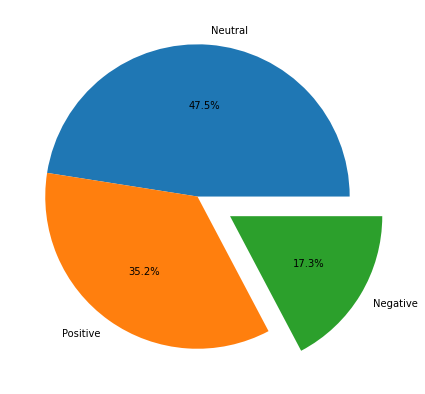

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

tb_count= fin_data.Analysis.value_counts()
plt.figure(figsize=(10, 7))
plt.pie(tb_counts.values, labels = tb_counts.index, explode = (0, 0, 0.25), autopct='%1.1f%%', shadow=False)

In [18]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# function to calculate vader sentiment  
def vadersentimentanalysis(review):
    vs = analyzer.polarity_scores(review)
    return vs['compound']

fin_data['Vader Sentiment'] = fin_data['Lemma'].apply(vadersentimentanalysis)

In [19]:
# function to analyse 
def vader_analysis(compound):
    if compound >= 0.5:
        return 'Positive'
    elif compound <= -0.5 :
        return 'Negative'
    else:
        return 'Neutral'
    
fin_data['Vader Analysis'] = fin_data['Vader Sentiment'].apply(vader_analysis)
fin_data.head()

,text,Lemma,Polarity,Analysis,Vader Sentiment,Vader Analysis
0,RT @NancyLeeGrahn: How did everyone feel about...,RT NancyLeeGrahn everyone feel Climate Chang...,0.1250,Positive,0.0000,Neutral
1,RT @ScottWalker: Didn't catch the full #GOPdeb...,RT ScottWalker catch full GOPdebate last nig...,0.3375,Positive,0.6369,Positive
2,RT @TJMShow: No mention of Tamir Rice and the ...,RT TJMShow mention Tamir Rice GOPDebate hold...,0.1000,Positive,0.5859,Positive
3,RT @RobGeorge: That Carly Fiorina is trending ...,RT RobGeorge Carly Fiorina trend hour debate...,0.1000,Positive,0.0000,Neutral
4,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,RT DanScavino GOPDebate w realDonaldTrump de...,0.1600,Positive,0.0000,Neutral


In [20]:
vader_counts = fin_data['Vader Analysis'].value_counts()
vader_counts

Neutral     9752
Positive    2443
Negative    1676
Name: Vader Analysis, dtype: int64

([<matplotlib.patches.Wedge at 0x24a26856100>,
 [Text(-0.7146106524112953, 0.9640184725721304, 'Neutral'),
  Text(0.2809893415436816, -1.0635059896111767, 'Positive'),
  Text(1.021697839838303, -0.4075948037815812, 'Negative')],
 [Text(-0.4168562139065889, 0.5623441090004093, '70.3%'),
  Text(0.15326691356928088, -0.5800941761515509, '17.6%'),
  Text(0.5572897308208924, -0.222324438426317, '12.1%')])

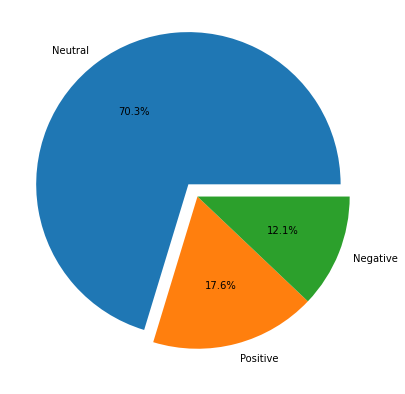

In [21]:
vader_counts= fin_data['Vader Analysis'].value_counts()
plt.figure(figsize=(10, 7))
plt.pie(vader_counts.values, labels = vader_counts.index, explode = (0.1, 0, 0), autopct='%1.1f%%', shadow=False)

In [22]:
nltk.download('sentiwordnet')
from nltk.corpus import sentiwordnet as swn

def sentiwordnetanalysis(pos_data):
    sentiment = 0
    tokens_count = 0
    for word, pos in pos_data:
        if not pos:
            continue
        lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
        if not lemma:
            continue
        
        synsets = wordnet.synsets(lemma, pos=pos)
        if not synsets:
            continue

        # Take the first sense, the most common
        synset = synsets[0]
        swn_synset = swn.senti_synset(synset.name())
        sentiment += swn_synset.pos_score() - swn_synset.neg_score()
        tokens_count += 1
        # print(swn_synset.pos_score(),swn_synset.neg_score(),swn_synset.obj_score())
    if not tokens_count:
        return 0
    if sentiment>0:
        return "Positive"
    if sentiment==0:
        return "Neutral"
    else:
        return "Negative"

fin_data['SWN analysis'] = dataset['POS'].apply(sentiwordnetanalysis)
fin_data.head()

[nltk_data] Downloading package sentiwordnet to
[nltk_data]     C:\Users\Maestro\AppData\Roaming\nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


,text,Lemma,Polarity,Analysis,Vader Sentiment,Vader Analysis,SWN analysis
0,RT @NancyLeeGrahn: How did everyone feel about...,RT NancyLeeGrahn everyone feel Climate Chang...,0.1250,Positive,0.0000,Neutral,Negative
1,RT @ScottWalker: Didn't catch the full #GOPdeb...,RT ScottWalker catch full GOPdebate last nig...,0.3375,Positive,0.6369,Positive,Positive
2,RT @TJMShow: No mention of Tamir Rice and the ...,RT TJMShow mention Tamir Rice GOPDebate hold...,0.1000,Positive,0.5859,Positive,Negative
3,RT @RobGeorge: That Carly Fiorina is trending ...,RT RobGeorge Carly Fiorina trend hour debate...,0.1000,Positive,0.0000,Neutral,Neutral
4,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,RT DanScavino GOPDebate w realDonaldTrump de...,0.1600,Positive,0.0000,Neutral,Negative


In [23]:
swn_counts= fin_data['SWN analysis'].value_counts()
swn_counts

Positive    5989
Negative    4219
Neutral     3638
0             25
Name: SWN analysis, dtype: int64

In [24]:
import matplotlib.pyplot as plt

([<matplotlib.patches.Wedge at 0x24a2d1e70d0>,
 [Text(0.23400435018219426, 1.0748218290004206, 'Positive'),
  Text(-0.9508582850710655, -0.5530538144807542, 'Negative'),
  Text(0.7380657512183892, -0.8156340765799543, 'Neutral'),
  Text(1.0999823680342276, -0.006228162956532336, '0')],
 [Text(0.12763873646301505, 0.5862664521820474, '43.2%'),
  Text(-0.5186499736751266, -0.3016657169895023, '30.4%'),
  Text(0.4025813188463941, -0.4448913144981569, '26.2%'),
  Text(0.5999903825641241, -0.0033971797944721827, '0.2%')])

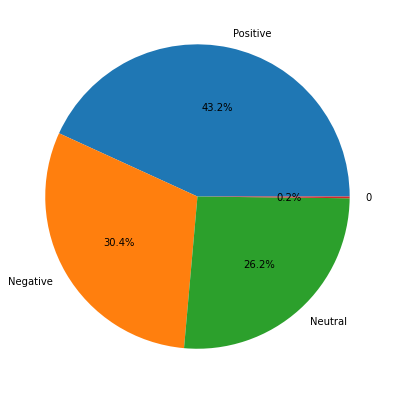

In [25]:
swn_counts= fin_data['SWN analysis'].value_counts()
plt.figure(figsize=(10, 7))
plt.pie(swn_counts.values, labels = swn_counts.index, autopct='%1.1f%%', shadow=False)

([<matplotlib.patches.Wedge at 0x24a2d2de280>,
 [Text(0.23400435018219426, 1.0748218290004206, 'Positive'),
  Text(-0.9508582850710655, -0.5530538144807542, 'Negative'),
  Text(0.7380657512183892, -0.8156340765799543, 'Neutral'),
  Text(1.0999823680342276, -0.006228162956532336, '0')],
 [Text(0.12763873646301505, 0.5862664521820474, '43.2%'),
  Text(-0.5186499736751266, -0.3016657169895023, '30.4%'),
  Text(0.4025813188463941, -0.4448913144981569, '26.2%'),
  Text(0.5999903825641241, -0.0033971797944721827, '0.2%')])

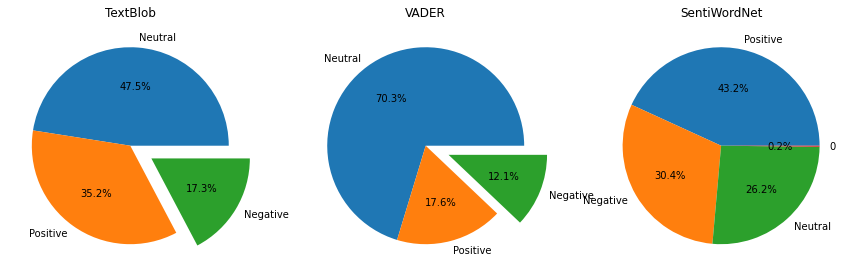

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(15,7))
plt.subplot(1,3,1)
plt.title("TextBlob")
plt.pie(tb_counts.values, labels = tb_counts.index, explode = (0, 0, 0.25), autopct='%1.1f%%', shadow=False)
plt.subplot(1,3,2)
plt.title("VADER")
plt.pie(vader_counts.values, labels = vader_counts.index, explode = (0, 0, 0.25), autopct='%1.1f%%', shadow=False)
plt.subplot(1,3,3)
plt.title("SentiWordNet")
plt.pie(swn_counts.values, labels = swn_counts.index, autopct='%1.1f%%', shadow=False)

In [27]:
import numpy as np 
import pandas as pd 
import re
import nltk 
import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
po_tweets = pd.read_csv('E:/MCD/Documentos/Sentiment.csv')

In [29]:
plot_size = plt.rcParams["figure.figsize"] 
print(plot_size[0]) 
print(plot_size[1])

plot_size[0] = 8
plot_size[1] = 6
plt.rcParams["figure.figsize"] = plot_size

6.0
4.0


<AxesSubplot:ylabel='candidate'>

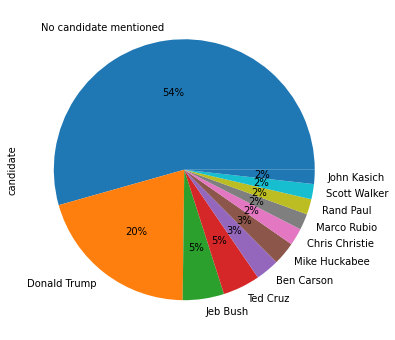

In [30]:
po_tweets.candidate.value_counts().plot(kind='pie', autopct='%1.0f%%')

<AxesSubplot:ylabel='sentiment'>

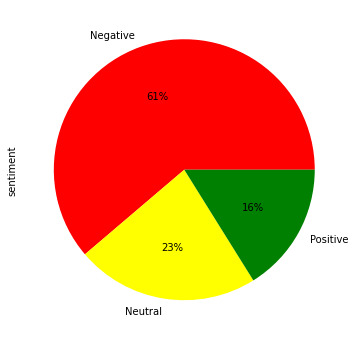

In [31]:
po_tweets.sentiment.value_counts().plot(kind='pie', autopct='%1.0f%%', colors=["red", "yellow", "green"])

<AxesSubplot:xlabel='candidate'>

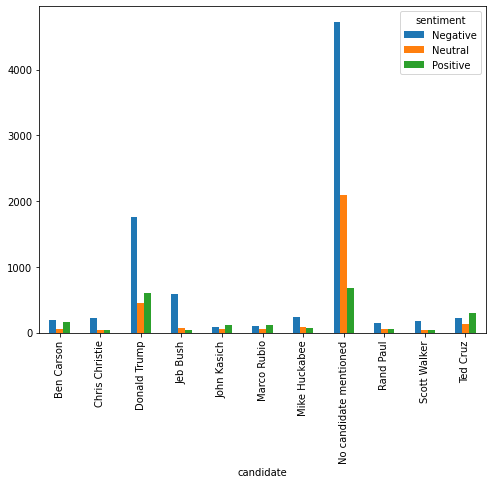

In [32]:
po_sentiment = po_tweets.groupby(['candidate', 'sentiment']).sentiment.count().unstack()
po_sentiment.plot(kind='bar')

<AxesSubplot:xlabel='sentiment', ylabel='sentiment_confidence'>

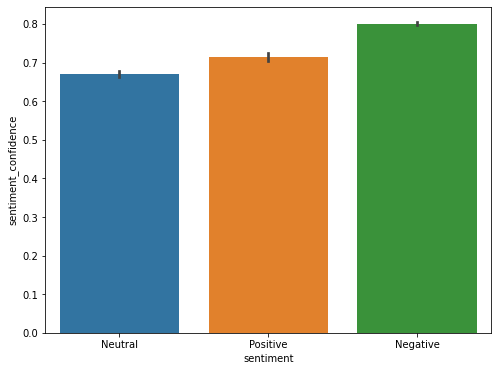

In [33]:
import seaborn as sns

sns.barplot(x='sentiment', y='sentiment_confidence' , data=po_tweets)

In [34]:
features = po_tweets.iloc[:, 15].values
labels = po_tweets.iloc[:, 5].values

In [35]:
processed_features = []

for sentence in range(0, len(features)):
    # Remove all the special characters
    processed_feature = re.sub(r'\W', ' ', str(features[sentence]))
    # remove all single characters
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)
    # Remove single characters from the start
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature) 
    # Substituting multiple spaces with single space
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)
    # Removing prefixed 'b'
    processed_feature = re.sub(r'^b\s+', '', processed_feature)
    # Converting to Lowercase
    processed_feature = processed_feature.lower()

    processed_features.append(processed_feature)

In [36]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer (max_features=2500, min_df=7, max_df=0.8, stop_words=stopwords.words('english'))
processed_features = vectorizer.fit_transform(processed_features).toarray()

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(processed_features, labels, test_size=0.2, random_state=0)

In [38]:
from sklearn.ensemble import RandomForestClassifier

text_classifier = RandomForestClassifier(n_estimators=200, random_state=0)
text_classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=0)

In [39]:
predictions = text_classifier.predict(X_test)

In [40]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

[[1521  110   39]
 [ 428  182   32]
 [ 219   43  201]]
              precision    recall  f1-score   support

    Negative       0.70      0.91      0.79      1670
     Neutral       0.54      0.28      0.37       642
    Positive       0.74      0.43      0.55       463

    accuracy                           0.69      2775
   macro avg       0.66      0.54      0.57      2775
weighted avg       0.67      0.69      0.65      2775

0.6861261261261261


## Sólo con los políticos

In [41]:
onlypo['Limpio'] = onlypo['text'].apply(clean)
onlypo.head()

,candidate,sentiment,sentiment_confidence,name,retweet_count,text,tweet_created,user_timezone,Limpio
1,Scott Walker,Positive,0.6333,PeacefulQuest,26,RT @ScottWalker: Didn't catch the full #GOPdeb...,2015-08-07 09:54:46 -0700,NaN,RT ScottWalker Didn t catch the full GOPdebate...
4,Donald Trump,Positive,0.7045,sharonDay5,156,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,2015-08-07 09:54:45 -0700,Arizona,RT DanScavino GOPDebate w realDonaldTrump deli...
5,Ted Cruz,Positive,0.6332,DRJohnson11,228,"RT @GregAbbott_TX: @TedCruz: ""On my first day ...",2015-08-07 09:54:44 -0700,Central Time (US & Canada),RT GregAbbott TX TedCruz On my first day I wil...
8,Ben Carson,Negative,0.6889,kengpdx,0,Deer in the headlights RT @lizzwinstead: Ben C...,2015-08-07 09:54:44 -0700,Pacific Time (US & Canada),Deer in the headlights RT lizzwinstead Ben Car...
10,Donald Trump,Negative,1.0000,jnjsmom,0,@JGreenDC @realDonaldTrump In all fairness #Bi...,2015-08-07 09:54:42 -0700,Central Time (US & Canada),JGreenDC realDonaldTrump In all fairness Bill...


In [42]:
onlypo['POS'] = onlypo['Limpio'].apply(token_stop_pos)
onlypo.head()

,candidate,sentiment,sentiment_confidence,name,retweet_count,text,tweet_created,user_timezone,Limpio,POS
1,Scott Walker,Positive,0.6333,PeacefulQuest,26,RT @ScottWalker: Didn't catch the full #GOPdeb...,2015-08-07 09:54:46 -0700,NaN,RT ScottWalker Didn t catch the full GOPdebate...,"[(RT, n), (ScottWalker, n), (catch, v), (full,..."
4,Donald Trump,Positive,0.7045,sharonDay5,156,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,2015-08-07 09:54:45 -0700,Arizona,RT DanScavino GOPDebate w realDonaldTrump deli...,"[(RT, n), (DanScavino, n), (GOPDebate, n), (w,..."
5,Ted Cruz,Positive,0.6332,DRJohnson11,228,"RT @GregAbbott_TX: @TedCruz: ""On my first day ...",2015-08-07 09:54:44 -0700,Central Time (US & Canada),RT GregAbbott TX TedCruz On my first day I wil...,"[(RT, n), (GregAbbott, n), (TX, n), (TedCruz, ..."
8,Ben Carson,Negative,0.6889,kengpdx,0,Deer in the headlights RT @lizzwinstead: Ben C...,2015-08-07 09:54:44 -0700,Pacific Time (US & Canada),Deer in the headlights RT lizzwinstead Ben Car...,"[(Deer, n), (headlights, n), (RT, n), (lizzwin..."
10,Donald Trump,Negative,1.0000,jnjsmom,0,@JGreenDC @realDonaldTrump In all fairness #Bi...,2015-08-07 09:54:42 -0700,Central Time (US & Canada),JGreenDC realDonaldTrump In all fairness Bill...,"[(JGreenDC, n), (realDonaldTrump, n), (fairnes..."


In [43]:
onlypo['Lemma'] = onlypo['POS'].apply(lemmatize)
onlypo.head()

,candidate,sentiment,sentiment_confidence,name,retweet_count,text,tweet_created,user_timezone,Limpio,POS,Lemma
1,Scott Walker,Positive,0.6333,PeacefulQuest,26,RT @ScottWalker: Didn't catch the full #GOPdeb...,2015-08-07 09:54:46 -0700,NaN,RT ScottWalker Didn t catch the full GOPdebate...,"[(RT, n), (ScottWalker, n), (catch, v), (full,...",RT ScottWalker catch full GOPdebate last nig...
4,Donald Trump,Positive,0.7045,sharonDay5,156,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,2015-08-07 09:54:45 -0700,Arizona,RT DanScavino GOPDebate w realDonaldTrump deli...,"[(RT, n), (DanScavino, n), (GOPDebate, n), (w,...",RT DanScavino GOPDebate w realDonaldTrump de...
5,Ted Cruz,Positive,0.6332,DRJohnson11,228,"RT @GregAbbott_TX: @TedCruz: ""On my first day ...",2015-08-07 09:54:44 -0700,Central Time (US & Canada),RT GregAbbott TX TedCruz On my first day I wil...,"[(RT, n), (GregAbbott, n), (TX, n), (TedCruz, ...",RT GregAbbott TX TedCruz first day rescind e...
8,Ben Carson,Negative,0.6889,kengpdx,0,Deer in the headlights RT @lizzwinstead: Ben C...,2015-08-07 09:54:44 -0700,Pacific Time (US & Canada),Deer in the headlights RT lizzwinstead Ben Car...,"[(Deer, n), (headlights, n), (RT, n), (lizzwin...",Deer headlight RT lizzwinstead Ben Carson ma...
10,Donald Trump,Negative,1.0000,jnjsmom,0,@JGreenDC @realDonaldTrump In all fairness #Bi...,2015-08-07 09:54:42 -0700,Central Time (US & Canada),JGreenDC realDonaldTrump In all fairness Bill...,"[(JGreenDC, n), (realDonaldTrump, n), (fairnes...",JGreenDC realDonaldTrump fairness BillClinto...


In [44]:
onlypo[['text', 'Lemma']]

,text,Lemma
1,RT @ScottWalker: Didn't catch the full #GOPdeb...,RT ScottWalker catch full GOPdebate last nig...
4,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,RT DanScavino GOPDebate w realDonaldTrump de...
5,"RT @GregAbbott_TX: @TedCruz: ""On my first day ...",RT GregAbbott TX TedCruz first day rescind e...
8,Deer in the headlights RT @lizzwinstead: Ben C...,Deer headlight RT lizzwinstead Ben Carson ma...
10,@JGreenDC @realDonaldTrump In all fairness #Bi...,JGreenDC realDonaldTrump fairness BillClinto...
...,...,...
13865,RT @RWSurferGirl: Fox is cherry picking the ca...,RT RWSurferGirl Fox cherry pick candidate Je...
13867,RT @georgehenryw: Who thought Huckabee exceede...,RT georgehenryw think Huckabee exceed expect...
13868,"RT @Lrihendry: #TedCruz As President, I will a...",RT Lrihendry TedCruz President always tell t...
13869,RT @JRehling: #GOPDebate Donald Trump says tha...,RT JRehling GOPDebate Donald Trump say time ...


In [45]:
fin_data = pd.DataFrame(onlypo[['text', 'Lemma']])

In [46]:
fin_data['Polarity'] = fin_data['Lemma'].apply(getPolarity) 
fin_data['Analysis'] = fin_data['Polarity'].apply(analysis)
fin_data.head()

,text,Lemma,Polarity,Analysis
1,RT @ScottWalker: Didn't catch the full #GOPdeb...,RT ScottWalker catch full GOPdebate last nig...,0.3375,Positive
4,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,RT DanScavino GOPDebate w realDonaldTrump de...,0.1600,Positive
5,"RT @GregAbbott_TX: @TedCruz: ""On my first day ...",RT GregAbbott TX TedCruz first day rescind e...,-0.0500,Negative
8,Deer in the headlights RT @lizzwinstead: Ben C...,Deer headlight RT lizzwinstead Ben Carson ma...,0.0000,Neutral
10,@JGreenDC @realDonaldTrump In all fairness #Bi...,JGreenDC realDonaldTrump fairness BillClinto...,0.6000,Positive


In [47]:
tb_counts = fin_data.Analysis.value_counts()
tb_counts

Neutral     3202
Positive    2036
Negative    1046
Name: Analysis, dtype: int64

([<matplotlib.patches.Wedge at 0x24a4e6a0940>,
 [Text(-0.032990806607029785, 1.0995051644623675, 'Neutral'),
  Text(-0.5205358058561896, -0.9690420397597038, 'Positive'),
  Text(1.1695840896637224, -0.6742203328330302, 'Negative')],
 [Text(-0.017994985422016246, 0.5997300897067458, '51.0%'),
  Text(-0.28392862137610336, -0.5285683853234747, '32.4%'),
  Text(0.736404797195677, -0.4245090984504264, '16.6%')])

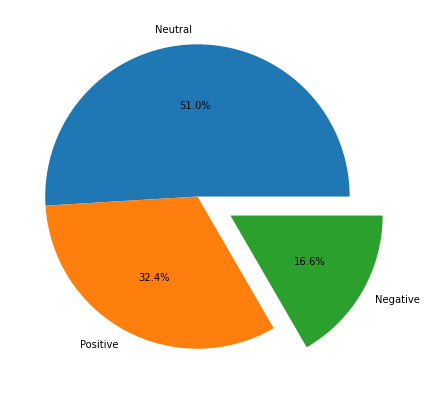

In [48]:
%matplotlib inline

tb_count= fin_data.Analysis.value_counts()
plt.figure(figsize=(10, 7))
plt.pie(tb_counts.values, labels = tb_counts.index, explode = (0, 0, 0.25), autopct='%1.1f%%', shadow=False)

In [49]:
fin_data['Vader Sentiment'] = fin_data['Lemma'].apply(vadersentimentanalysis)

In [50]:
fin_data['Vader Analysis'] = fin_data['Vader Sentiment'].apply(vader_analysis)
fin_data.head()

,text,Lemma,Polarity,Analysis,Vader Sentiment,Vader Analysis
1,RT @ScottWalker: Didn't catch the full #GOPdeb...,RT ScottWalker catch full GOPdebate last nig...,0.3375,Positive,0.6369,Positive
4,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,RT DanScavino GOPDebate w realDonaldTrump de...,0.1600,Positive,0.0000,Neutral
5,"RT @GregAbbott_TX: @TedCruz: ""On my first day ...",RT GregAbbott TX TedCruz first day rescind e...,-0.0500,Negative,-0.0943,Neutral
8,Deer in the headlights RT @lizzwinstead: Ben C...,Deer headlight RT lizzwinstead Ben Carson ma...,0.0000,Neutral,0.0000,Neutral
10,@JGreenDC @realDonaldTrump In all fairness #Bi...,JGreenDC realDonaldTrump fairness BillClinto...,0.6000,Positive,0.0000,Neutral


In [51]:
vader_counts = fin_data['Vader Analysis'].value_counts()
vader_counts

Neutral     4319
Positive    1057
Negative     908
Name: Vader Analysis, dtype: int64

([<matplotlib.patches.Wedge at 0x24a4e708490>,
 [Text(-0.6660606820206738, 0.9981799276013092, 'Neutral'),
  Text(0.14748543164963734, -1.0900679095593633, 'Positive'),
  Text(0.9885984844452821, -0.4823619352234292, 'Negative')],
 [Text(-0.388535397845393, 0.582271624434097, '68.7%'),
  Text(0.08044659908162037, -0.5945824961232891, '16.8%'),
  Text(0.5392355369701538, -0.2631065101218704, '14.4%')])

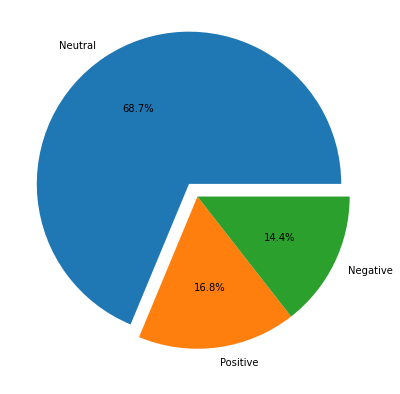

In [52]:
vader_counts= fin_data['Vader Analysis'].value_counts()
plt.figure(figsize=(10, 7))
plt.pie(vader_counts.values, labels = vader_counts.index, explode = (0.1, 0, 0), autopct='%1.1f%%', shadow=False)

In [53]:
fin_data['SWN analysis'] = dataset['POS'].apply(sentiwordnetanalysis)
fin_data.head()

,text,Lemma,Polarity,Analysis,Vader Sentiment,Vader Analysis,SWN analysis
1,RT @ScottWalker: Didn't catch the full #GOPdeb...,RT ScottWalker catch full GOPdebate last nig...,0.3375,Positive,0.6369,Positive,Positive
4,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,RT DanScavino GOPDebate w realDonaldTrump de...,0.1600,Positive,0.0000,Neutral,Negative
5,"RT @GregAbbott_TX: @TedCruz: ""On my first day ...",RT GregAbbott TX TedCruz first day rescind e...,-0.0500,Negative,-0.0943,Neutral,Positive
8,Deer in the headlights RT @lizzwinstead: Ben C...,Deer headlight RT lizzwinstead Ben Carson ma...,0.0000,Neutral,0.0000,Neutral,Positive
10,@JGreenDC @realDonaldTrump In all fairness #Bi...,JGreenDC realDonaldTrump fairness BillClinto...,0.6000,Positive,0.0000,Neutral,Neutral


In [54]:
swn_counts= fin_data['SWN analysis'].value_counts()
swn_counts

Positive    2880
Negative    1786
Neutral     1610
0              8
Name: SWN analysis, dtype: int64

([<matplotlib.patches.Wedge at 0x24a4e75a1c0>,
 [Text(0.14366965333381534, 1.0905773841002488, 'Positive'),
  Text(-0.8882348187568564, -0.6488751087443366, 'Negative'),
  Text(0.7561389577669066, -0.7989079274529552, 'Neutral'),
  Text(1.0999912025322274, -0.004399358101414309, '0')],
 [Text(0.07836526545480836, 0.5948603913274083, '45.8%'),
  Text(-0.4844917193219216, -0.35393187749691085, '28.4%'),
  Text(0.41243943150922174, -0.4357679604288846, '25.6%'),
  Text(0.5999952013812149, -0.002399649873498714, '0.1%')])

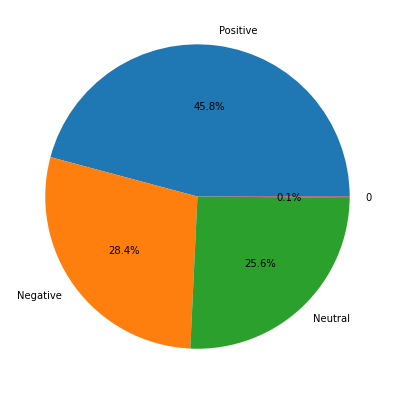

In [55]:
swn_counts= fin_data['SWN analysis'].value_counts()
plt.figure(figsize=(10, 7))
plt.pie(swn_counts.values, labels = swn_counts.index, autopct='%1.1f%%', shadow=False)

([<matplotlib.patches.Wedge at 0x24a4e82ec40>,
 [Text(0.14366965333381534, 1.0905773841002488, 'Positive'),
  Text(-0.8882348187568564, -0.6488751087443366, 'Negative'),
  Text(0.7561389577669066, -0.7989079274529552, 'Neutral'),
  Text(1.0999912025322274, -0.004399358101414309, '0')],
 [Text(0.07836526545480836, 0.5948603913274083, '45.8%'),
  Text(-0.4844917193219216, -0.35393187749691085, '28.4%'),
  Text(0.41243943150922174, -0.4357679604288846, '25.6%'),
  Text(0.5999952013812149, -0.002399649873498714, '0.1%')])

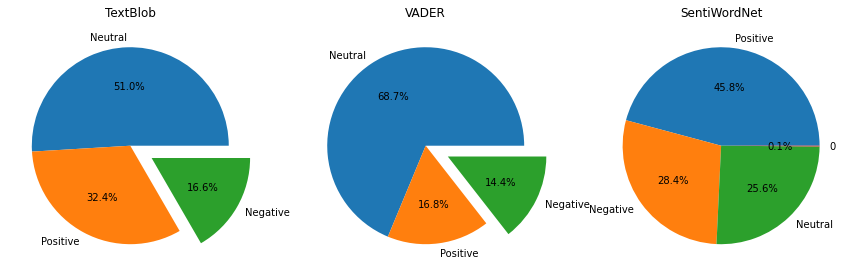

In [56]:
%matplotlib inline

plt.figure(figsize=(15,7))
plt.subplot(1,3,1)
plt.title("TextBlob")
plt.pie(tb_counts.values, labels = tb_counts.index, explode = (0, 0, 0.25), autopct='%1.1f%%', shadow=False)
plt.subplot(1,3,2)
plt.title("VADER")
plt.pie(vader_counts.values, labels = vader_counts.index, explode = (0, 0, 0.25), autopct='%1.1f%%', shadow=False)
plt.subplot(1,3,3)
plt.title("SentiWordNet")
plt.pie(swn_counts.values, labels = swn_counts.index, autopct='%1.1f%%', shadow=False)

In [57]:
plot_size = plt.rcParams["figure.figsize"] 
print(plot_size[0]) 
print(plot_size[1])

plot_size[0] = 8
plot_size[1] = 6
plt.rcParams["figure.figsize"] = plot_size

6.0
4.0


<AxesSubplot:ylabel='candidate'>

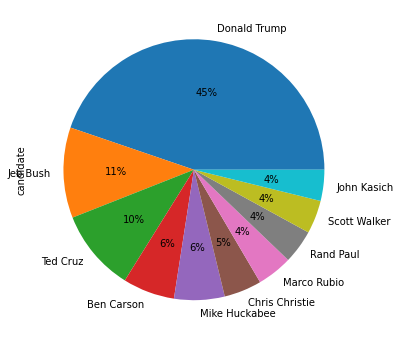

In [58]:
onlypo.candidate.value_counts().plot(kind='pie', autopct='%1.0f%%')

<AxesSubplot:ylabel='sentiment'>

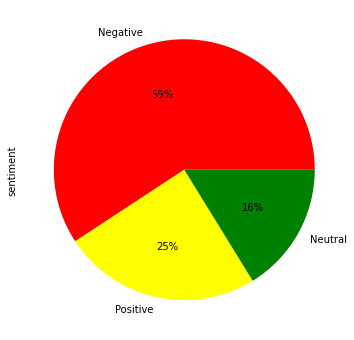

In [59]:
onlypo.sentiment.value_counts().plot(kind='pie', autopct='%1.0f%%', colors=["red", "yellow", "green"])

<AxesSubplot:xlabel='candidate'>

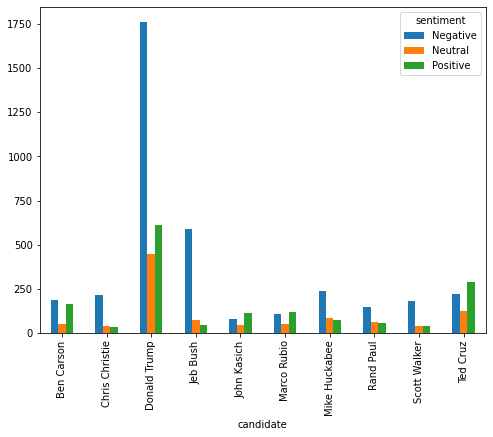

In [60]:
po_sentiment = onlypo.groupby(['candidate', 'sentiment']).sentiment.count().unstack()
po_sentiment.plot(kind='bar')

<AxesSubplot:xlabel='sentiment', ylabel='sentiment_confidence'>

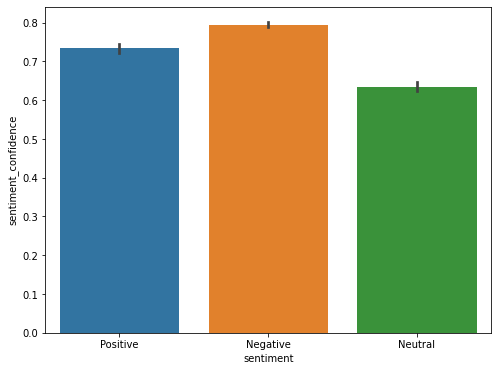

In [61]:
sns.barplot(x='sentiment', y='sentiment_confidence' , data=onlypo)

In [62]:
onlypo.head()

,candidate,sentiment,sentiment_confidence,name,retweet_count,text,tweet_created,user_timezone,Limpio,POS,Lemma
1,Scott Walker,Positive,0.6333,PeacefulQuest,26,RT @ScottWalker: Didn't catch the full #GOPdeb...,2015-08-07 09:54:46 -0700,NaN,RT ScottWalker Didn t catch the full GOPdebate...,"[(RT, n), (ScottWalker, n), (catch, v), (full,...",RT ScottWalker catch full GOPdebate last nig...
4,Donald Trump,Positive,0.7045,sharonDay5,156,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,2015-08-07 09:54:45 -0700,Arizona,RT DanScavino GOPDebate w realDonaldTrump deli...,"[(RT, n), (DanScavino, n), (GOPDebate, n), (w,...",RT DanScavino GOPDebate w realDonaldTrump de...
5,Ted Cruz,Positive,0.6332,DRJohnson11,228,"RT @GregAbbott_TX: @TedCruz: ""On my first day ...",2015-08-07 09:54:44 -0700,Central Time (US & Canada),RT GregAbbott TX TedCruz On my first day I wil...,"[(RT, n), (GregAbbott, n), (TX, n), (TedCruz, ...",RT GregAbbott TX TedCruz first day rescind e...
8,Ben Carson,Negative,0.6889,kengpdx,0,Deer in the headlights RT @lizzwinstead: Ben C...,2015-08-07 09:54:44 -0700,Pacific Time (US & Canada),Deer in the headlights RT lizzwinstead Ben Car...,"[(Deer, n), (headlights, n), (RT, n), (lizzwin...",Deer headlight RT lizzwinstead Ben Carson ma...
10,Donald Trump,Negative,1.0000,jnjsmom,0,@JGreenDC @realDonaldTrump In all fairness #Bi...,2015-08-07 09:54:42 -0700,Central Time (US & Canada),JGreenDC realDonaldTrump In all fairness Bill...,"[(JGreenDC, n), (realDonaldTrump, n), (fairnes...",JGreenDC realDonaldTrump fairness BillClinto...


In [63]:
features = onlypo.iloc[:, 5].values
labels = onlypo.iloc[:, 1].values

In [64]:
processed_features = []

for sentence in range(0, len(features)):
    # Remove all the special characters
    processed_feature = re.sub(r'\W', ' ', str(features[sentence]))
    # remove all single characters
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)
    # Remove single characters from the start
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature) 
    # Substituting multiple spaces with single space
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)
    # Removing prefixed 'b'
    processed_feature = re.sub(r'^b\s+', '', processed_feature)
    # Converting to Lowercase
    processed_feature = processed_feature.lower()

    processed_features.append(processed_feature)

In [65]:
vectorizer = TfidfVectorizer (max_features=2500, min_df=7, max_df=0.8, stop_words=stopwords.words('english'))
processed_features = vectorizer.fit_transform(processed_features).toarray()

In [66]:
X_train, X_test, y_train, y_test = train_test_split(processed_features, labels, test_size=0.2, random_state=0)

In [67]:
text_classifier = RandomForestClassifier(n_estimators=200, random_state=0)
text_classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=0)

In [68]:
predictions = text_classifier.predict(X_test)

In [69]:
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

[[679  24  41]
 [153  25  29]
 [147   6 153]]
              precision    recall  f1-score   support

    Negative       0.69      0.91      0.79       744
     Neutral       0.45      0.12      0.19       207
    Positive       0.69      0.50      0.58       306

    accuracy                           0.68      1257
   macro avg       0.61      0.51      0.52      1257
weighted avg       0.65      0.68      0.64      1257

0.6817820206841687


## Conclusiones

#### Se realizó un análisis de sentimientos utilizando las tres herramientas sobre toda la BD y se obtuvieron diferentes resultados en cada caso. Se repitió el análisis utilizando las tres herramientas con la BD reducida (sólo con nombres de políticos) y los resultados obtenidos fueron similares.
#### Una vez aplicado a los políticos con nombre, notamos que Donald Trump fue quien recibió la mayor cantidad de sentimientos negativos, siendo este el sentimiento con mayor confiabilidad. 
#### Se aplicó a ambos conjuntos de datos la red neuronal y el accuracy fue similar: 68%